<a href="https://colab.research.google.com/github/AleksandreBakhtadze/ML-abakh22-facial-expression-recognition/blob/main/facial_expression_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!pip install -q wandb
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [6]:
import wandb
wandb.login()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abakh22 (abakh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.17GB/s]


In [7]:
# Import libraries
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import numpy as np
from PIL import Image

In [8]:
# Data augmentation and transforms
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Function to get model summary
def get_model_summary(model, input_size):
    from io import StringIO
    import sys
    try:
        old_stdout = sys.stdout
        sys.stdout = StringIO()
        summary(model, input_size)
        model_summary = sys.stdout.getvalue()
        sys.stdout = old_stdout
        return model_summary
    except Exception as e:
        print(f"Error generating model summary with torchsummary: {e}")
        sys.stdout = old_stdout
        return str(model)  # Fallback to string representation of the model

# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
class ImprovedEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedEmotionCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
# Function to train and evaluate model
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, run_name):
    # Initialize Wandb with detailed config
    wandb.init(project="facial-expression-recognition", name=run_name, config={
        "epochs": epochs,
        "batch_size": 64,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "optimizer": optimizer.__class__.__name__,
        "architecture": model.__class__.__name__,
        "num_parameters": count_parameters(model),
        "dataset_size_train": len(train_dataset),
        "dataset_size_test": len(test_dataset),
        "classes": train_dataset.classes,
    })

    # Log model summary
    model_summary = get_model_summary(model, (1, 48, 48))
    wandb.log({"model_summary": wandb.Html(model_summary)})

    # Log dataset metadata (class distribution)
    class_counts = {}
    for cls in train_dataset.classes:
        class_counts[cls] = len([x for x, y in train_dataset.samples if train_dataset.classes[y] == cls])
    class_table = wandb.Table(data=[[k, v] for k, v in class_counts.items()], columns=["Class", "Count"])
    wandb.log({"class_distribution": class_table})

    model.to(device)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize metrics
    precision_metric = MulticlassPrecision(num_classes=len(train_dataset.classes), average=None).to(device)
    recall_metric = MulticlassRecall(num_classes=len(train_dataset.classes), average=None).to(device)
    f1_metric = MulticlassF1Score(num_classes=len(train_dataset.classes), average=None).to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Log gradient norm
            grad_norm = sum(p.grad.data.norm(2).item() ** 2 for p in model.parameters() if p.grad is not None) ** 0.5
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Log batch metrics
            batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)
            wandb.log({
                "batch": batch_idx + 1 + epoch * len(train_loader),
                "batch_train_loss": loss.item(),
                "batch_train_accuracy": batch_accuracy,
                "gradient_norm": grad_norm,
            })

        scheduler.step()
        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        confusion_matrix = MulticlassConfusionMatrix(num_classes=len(train_dataset.classes)).to(device)
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                confusion_matrix.update(predicted, labels)
                precision_metric.update(predicted, labels)
                recall_metric.update(predicted, labels)
                f1_metric.update(predicted, labels)

                # Log sample predictions (first batch only)
                if batch_idx == 0 and epoch == epochs - 1:
                    images_cpu = images.cpu().numpy()
                    images_cpu = (images_cpu * 0.5 + 0.5) * 255  # Denormalize
                    images_cpu = images_cpu.astype(np.uint8)
                    for i in range(min(5, images.size(0))):  # Log up to 5 images
                        img = Image.fromarray(images_cpu[i].squeeze())
                        wandb.log({
                            f"sample_prediction_{i}": wandb.Image(img, caption=f"True: {train_dataset.classes[labels[i]]}, Pred: {train_dataset.classes[predicted[i]]}")
                        })

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        precision = precision_metric.compute().cpu().numpy()
        recall = recall_metric.compute().cpu().numpy()
        f1 = f1_metric.compute().cpu().numpy()

        # Log metrics
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": scheduler.get_last_lr()[0],
            "precision_per_class": {train_dataset.classes[i]: precision[i] for i in range(len(train_dataset.classes))},
            "recall_per_class": {train_dataset.classes[i]: recall[i] for i in range(len(train_dataset.classes))},
            "f1_per_class": {train_dataset.classes[i]: f1[i] for i in range(len(train_dataset.classes))},
        })

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Log confusion matrix
    cm = confusion_matrix.compute().cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    wandb.log({"confusion_matrix": wandb.Image(plt)})

    # Save model and optimizer as artifacts
    torch.save(model.state_dict(), "model.pth")
    torch.save(optimizer.state_dict(), "optimizer.pth")
    artifact = wandb.Artifact(f"model_{run_name}", type="model")
    artifact.add_file("model.pth")
    artifact.add_file("optimizer.pth")
    wandb.log_artifact(artifact)

    wandb.finish()
    return val_accuracy

Epoch 1/10, Train Loss: 1.6125, Train Acc: 36.88%, Val Loss: 1.4001, Val Acc: 46.36%
Epoch 2/10, Train Loss: 1.4232, Train Acc: 45.20%, Val Loss: 1.2804, Val Acc: 50.22%
Epoch 3/10, Train Loss: 1.3366, Train Acc: 48.49%, Val Loss: 1.2290, Val Acc: 52.91%
Epoch 4/10, Train Loss: 1.2939, Train Acc: 50.65%, Val Loss: 1.1898, Val Acc: 55.03%
Epoch 5/10, Train Loss: 1.2584, Train Acc: 52.04%, Val Loss: 1.1706, Val Acc: 54.25%
Epoch 6/10, Train Loss: 1.1931, Train Acc: 55.10%, Val Loss: 1.1196, Val Acc: 57.05%
Epoch 7/10, Train Loss: 1.1650, Train Acc: 55.62%, Val Loss: 1.1059, Val Acc: 57.72%
Epoch 8/10, Train Loss: 1.1454, Train Acc: 56.22%, Val Loss: 1.0991, Val Acc: 58.15%
Epoch 9/10, Train Loss: 1.1442, Train Acc: 56.57%, Val Loss: 1.0942, Val Acc: 58.01%
Epoch 10/10, Train Loss: 1.1281, Train Acc: 57.03%, Val Loss: 1.0856, Val Acc: 58.69%


batch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
batch_train_accuracy,▁▂▄▄▅▅▄▃▅▅▅▃▅▅▅▅▆▆█▅▆▆▇▅▅▅▅▅▅▆▅▅▅▇▆▇▆▅▆▇
batch_train_loss,█▆▆▆▅▅▄▄▅▄▃▄▃▃▄▄▂▄▅▃▄▂▂▂▄▂▄▁▂▂▂▃▂▄▃▂▃▁▃▃
epoch,▁▂▃▃▄▅▆▆▇█
gradient_norm,▂▁▁▃▃▁▃▆▂▄▅▂▆▄▄▄█▅▅▄▅▄▅▃▄▂▅▃▄▆▆▄▅▄▅▇█▅█▆
learning_rate,████▂▂▂▂▂▁
train_accuracy,▁▄▅▆▆▇████
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▅▇▇███
val_loss,█▅▄▃▃▂▁▁▁▁
batch,4490


Epoch 1/10, Train Loss: 1.6732, Train Acc: 33.47%, Val Loss: 1.4851, Val Acc: 42.70%
Epoch 2/10, Train Loss: 1.5408, Train Acc: 39.98%, Val Loss: 1.3735, Val Acc: 46.38%
Epoch 3/10, Train Loss: 1.4758, Train Acc: 42.86%, Val Loss: 1.3621, Val Acc: 48.31%
Epoch 4/10, Train Loss: 1.4399, Train Acc: 44.44%, Val Loss: 1.3393, Val Acc: 46.82%
Epoch 5/10, Train Loss: 1.3896, Train Acc: 46.88%, Val Loss: 1.2663, Val Acc: 51.18%
Epoch 6/10, Train Loss: 1.2840, Train Acc: 50.82%, Val Loss: 1.1949, Val Acc: 54.18%
Epoch 7/10, Train Loss: 1.2483, Train Acc: 52.64%, Val Loss: 1.1787, Val Acc: 54.46%
Epoch 8/10, Train Loss: 1.2292, Train Acc: 53.48%, Val Loss: 1.1642, Val Acc: 55.11%
Epoch 9/10, Train Loss: 1.2193, Train Acc: 53.70%, Val Loss: 1.1583, Val Acc: 55.34%
Epoch 10/10, Train Loss: 1.2055, Train Acc: 54.23%, Val Loss: 1.1461, Val Acc: 55.92%


batch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
batch_train_accuracy,▁▁▃▄▃▅▃▃▄▅▆▅▅▅▅▄▆▅▅▄▄▆▇▅▅▇▆▇▅█▆▆▆▅▆▆▆▆█▆
batch_train_loss,▆▇█▆▄▆▅▅▆▇▆▄▃▅▅▅▄▂▅▃▄▃▃▃▃▁▄▃▃▃▄▁▃▃▁▂▃▃▃▄
epoch,▁▂▃▃▄▅▆▆▇█
gradient_norm,█▂▂▂▂▁▃▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▃▁▂▂▂▂▁▂▂▂▂▁▂
learning_rate,████▂▂▂▂▂▁
train_accuracy,▁▃▄▅▆▇▇███
train_loss,█▆▅▅▄▂▂▁▁▁
val_accuracy,▁▃▄▃▅▇▇███
val_loss,█▆▅▅▃▂▂▁▁▁
batch,4490


55.92086932293118

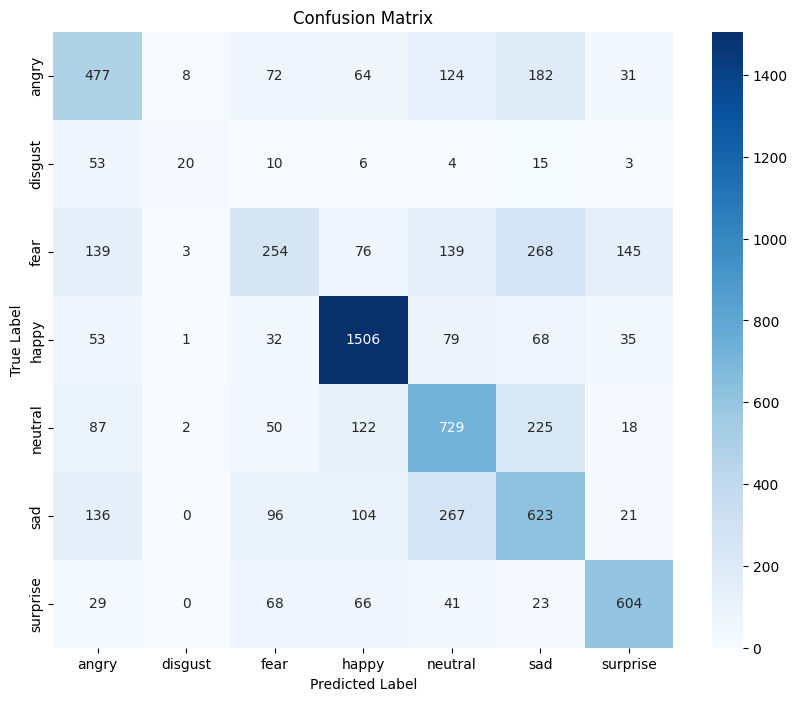

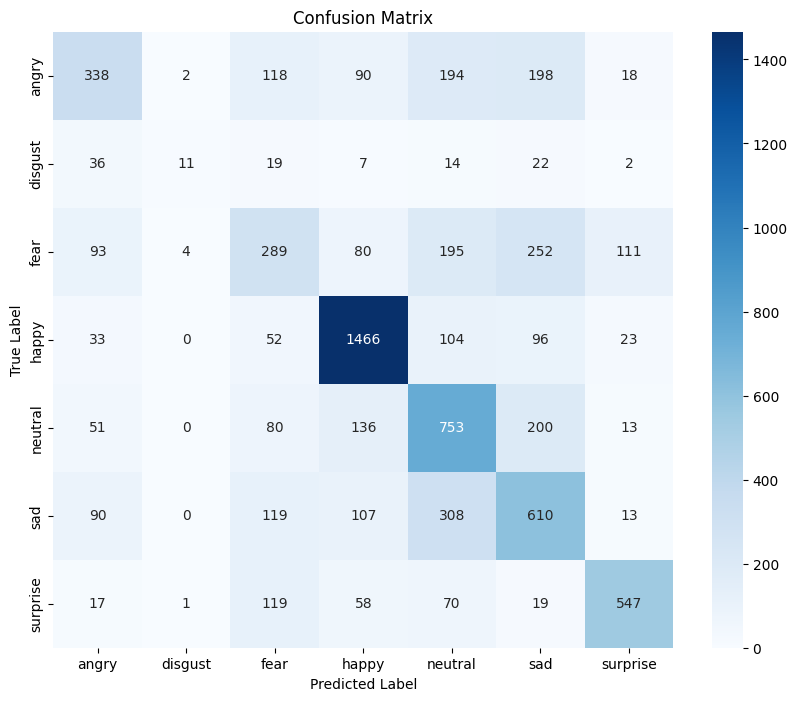

In [12]:
# Experiment with different architectures and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Experiment 1: Improved CNN with Adam
model = ImprovedEmotionCNN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, run_name="improved-cnn-adam")

# Experiment 2: Improved CNN with SGD + Momentum
model = ImprovedEmotionCNN(num_classes)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, run_name="improved-cnn-sgd")